# Elemental Mapping of QEMSCAN data

The following notebook outlines the current state of the code written which may be used for producing elemental maps from QEMSCAN data.

## Extras

The file QEMSCAN_mapping.py also contains some extra functions which may be useful. For example Gaussian Filtering for smoothing to be applied to the maps - this is actually fairly tricky due to the presence of "nan" values where no data exists, but the current function takes those into account effectively. Feature normalisation may also be applied - at the moment this is z-score normalisation only.


In [1]:
#import all libraries/modules required
import pandas as pd
import numpy as np
import os
import QEMSCAN_mapping as qf

## CSV Loading and Manipulation

In [2]:
#load CSV from QEMSCAN
full_path = os.path.expanduser("~/Desktop/QEMSCAN/TS_II/20210321_TSII_5micron.csv")

data = pd.read_csv(full_path,low_memory=False, header = 1)
data.head()

,X(um),Y(um),X,Y,Field ID,Particle ID,Mineral ID,Mineral Name,File Name,BSE,...,Po,At,Rn,Fr,Ra,Ac,Th,Pa,U,Unnamed: 133
0,-20865.814408,48954.0,326,0,1,17378913,1205,Low CR (T),NaN,38.26459,...,0,0,0,0,0,0,0.0,0,0.0,NaN
1,-13090.478632,48954.0,1918,0,1,17378913,546,Amphibole (Hornblende),NaN,55.29961,...,0,0,0,0,0,0,0.0,0,0.0,NaN
2,-13070.942613,48954.0,1922,0,1,17378913,546,Amphibole (Hornblende),NaN,55.29961,...,0,0,0,0,0,0,0.0,0,0.0,NaN
3,-13051.406593,48954.0,1926,0,1,17378913,546,Amphibole (Hornblende),NaN,55.72374,...,0,0,0,0,0,0,0.0,0,0.0,NaN
4,-13031.870574,48954.0,1930,0,1,17378913,546,Amphibole (Hornblende),NaN,51.17121,...,0,0,0,0,0,0,0.0,0,0.0,NaN


All the headers may be explored to see exactly what data is present in the CSV file:

In [3]:
print(data.columns.values.tolist())

['X(um)', 'Y(um)', 'X', 'Y', 'Field ID', 'Particle ID', 'Mineral ID', 'Mineral Name', 'File Name', 'BSE', 'Count Rate', 'Live Time', 'Counts', 'SAE Confidence', 'Xray Index', 'C', 'O', 'F', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'K', 'Ca', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'As', 'Ag', 'Sn', 'Sb', 'Ba', 'Ce', 'W', 'Au', 'Pb', 'Bi', 'C.1', 'N', 'O.1', 'F.1', 'Ne', 'Na.1', 'Mg.1', 'Al.1', 'Si.1', 'P.1', 'S.1', 'Cl.1', 'Ar', 'K.1', 'Ca.1', 'Sc', 'Ti.1', 'V.1', 'Cr.1', 'Mn.1', 'Fe.1', 'Co.1', 'Ni.1', 'Cu.1', 'Zn.1', 'Ga', 'Ge', 'As.1', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y.1', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag.1', 'Cd', 'In', 'Sn.1', 'Sb.1', 'Te', 'I', 'Xe', 'Cs', 'Ba.1', 'La', 'Ce.1', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W.1', 'Re', 'Os', 'Ir', 'Pt', 'Au.1', 'Hg', 'Tl', 'Pb.1', 'Bi.1', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U', 'Unnamed: 133']


Reduce the dataframe so only the information we care about is shown in the table:

In [4]:
data_reduced = data.loc[:, ['X(um)', 'Y(um)', 'X','Y', 'Na','Mg','Al','Si','Ca', 'Fe', 'O']]
data_reduced.head()

,X(um),Y(um),X,Y,Na,Mg,Al,Si,Ca,Fe,O
0,-20865.814408,48954.0,326,0,0.0,51.627041,51.374680,167.424713,52.0,27.226883,67.800003
1,-13090.478632,48954.0,1918,0,0.0,29.365040,55.315056,253.478394,103.0,51.521149,38.799999
2,-13070.942613,48954.0,1922,0,0.0,37.103039,64.297829,222.255600,104.0,40.340126,41.299999
3,-13051.406593,48954.0,1926,0,0.0,29.169840,54.513657,224.704422,92.5,53.677238,47.299999
4,-13031.870574,48954.0,1930,0,0.0,32.263439,58.072140,223.433838,88.5,46.134392,41.299999


In [5]:
#save using the following command below

#data_reduced.to_csv("file name")

## Building cocentration "data-cube" and its uses

For most operations, having a dataframe as above is not great as although the pixel locations are shown, there is no easy way to plot the data in Python as it is stored above. This is made even worse by the fact that any pixels where QEMSCAN did not collect any data, as no minerals were recognised there, are ignored in the above table. 

Therefore a specific function was written to transform the data into a 3D "data-cube" (2 spatial and 1 'element' dimension) in the more useful Numpy ndarray format. With this an additional binary mask is also created to show at which points there exists data and those where none is present; pixels without data are assing the "Nan" variable. This additional image may be important in later operations to filter out the "Nan" values and subsequently reconstructing the images back to their original forms.

In [6]:
conc_cube, data_mask = qf.build_conc_map(data_reduced.loc[:,['X', 'Y','Na','Mg','Al','Si','Ca', 'Fe', 'O']])

Starting to build data-cube.
Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%
Progress: 90%
Progress: 100%


In [5]:
conc_cube = np.load("conc_map.npy")

In [6]:
conc_cube.shape

(3781, 7363, 7)

In [7]:
conc_list = qf.stack2list(conc_cube)
conc_list

[array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ..

In [8]:
#the above can be saved to a numpy binary using the below command:
#np.save("name", conc_cube)

#then load using np.load()

In [9]:
elements = ['Na','Mg','Al','Si','Ca', 'Fe', 'O']
qf.Maps2PDF(conc_cube, elements, file_name="Maps")

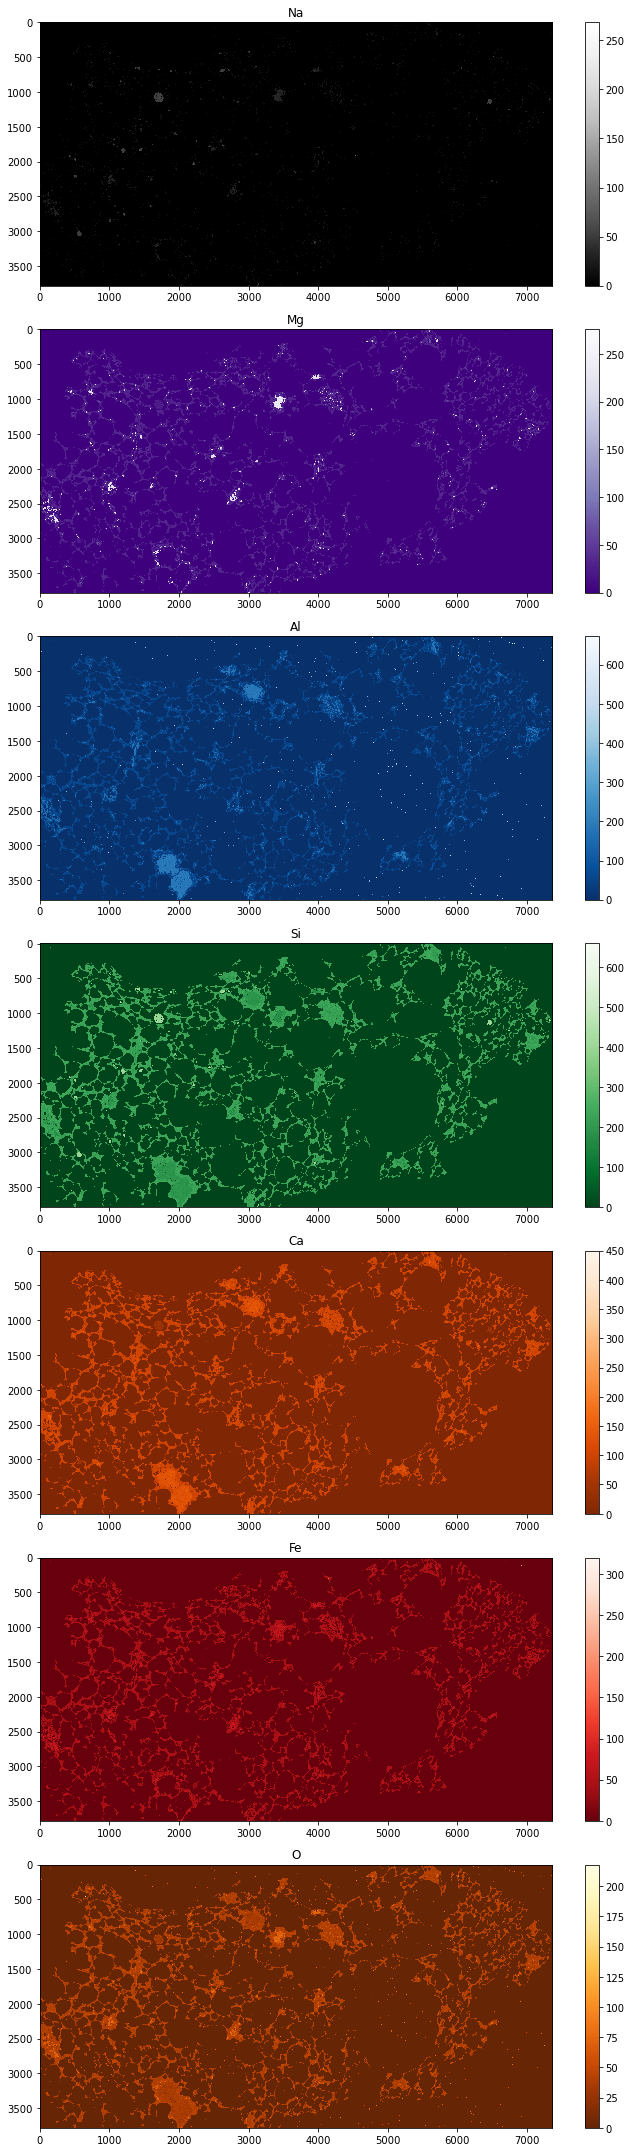

In [10]:
fig, ax = qf.plot_intensity_maps(conc_cube, elements, grid = (7,1), show_axis="on", figsize = (12,30))

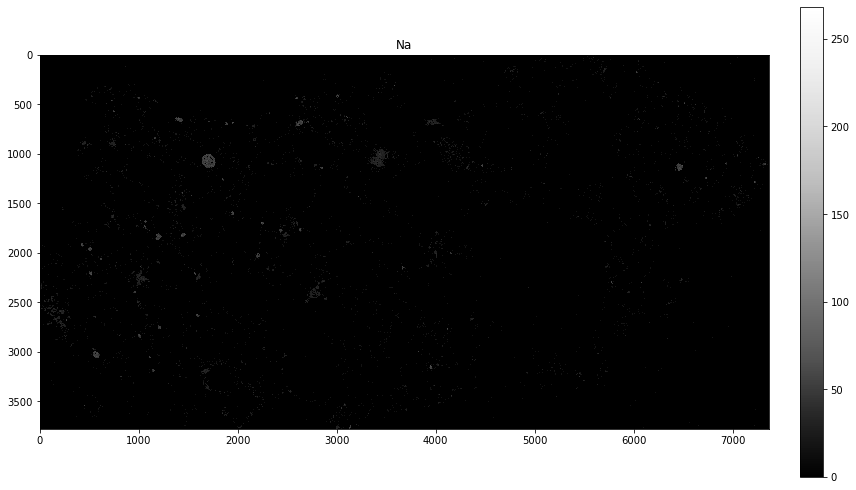

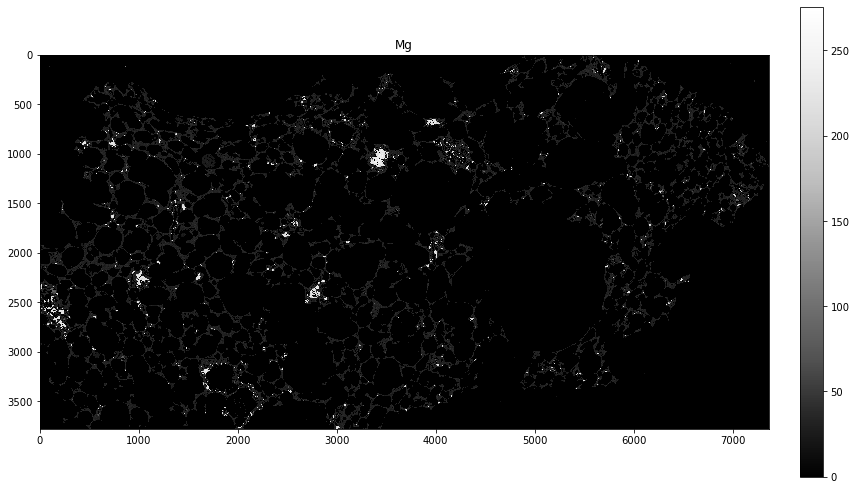

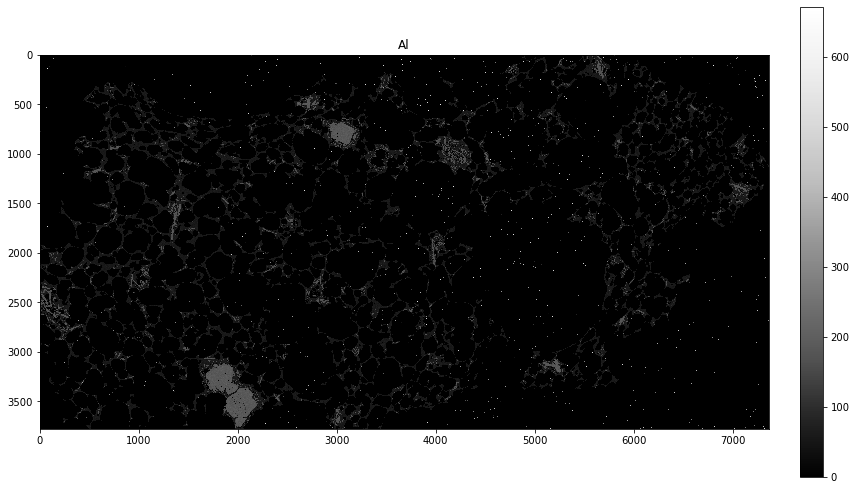

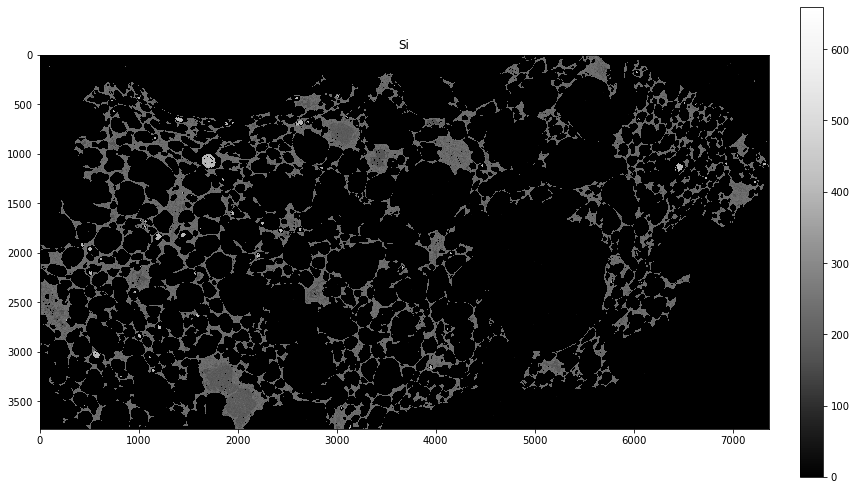

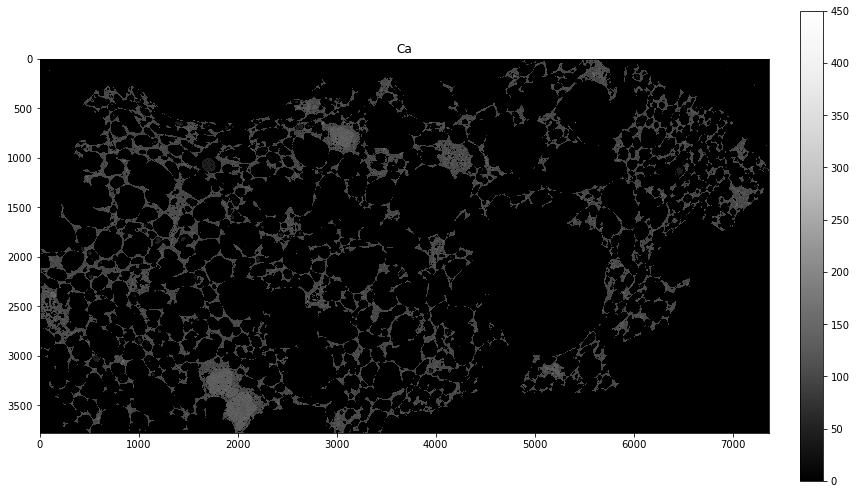

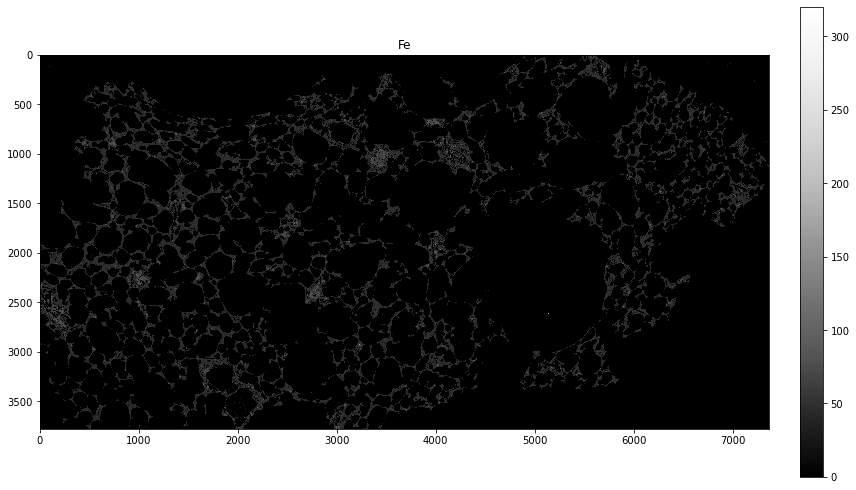

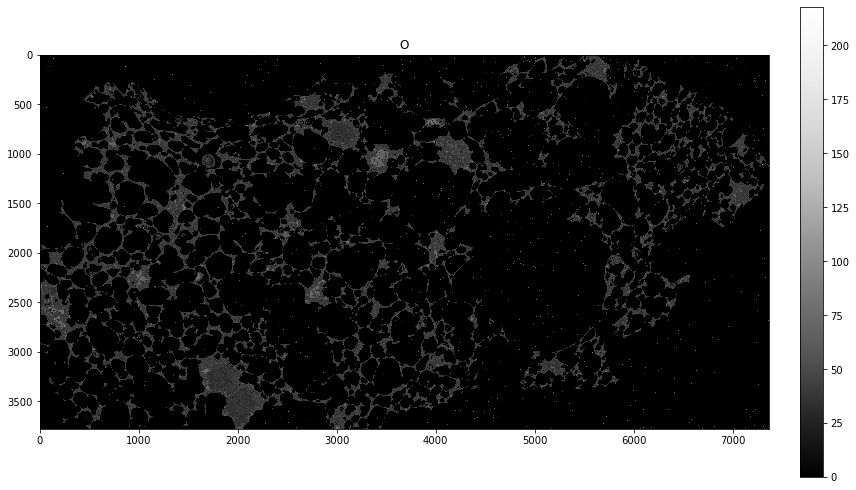

In [11]:
for i in range(7):
    fig, ax = qf.plot_intensity_maps(conc_cube[:,:,i], elements[i], grid = (1,1), show_axis="on", figsize = (12,12), fraction_pad = (0.03,0.04)) 
    #colorbar can be modified by changing fraction_pad which sets the "fraction" and "pad" parameters of the matplotlib colorbar object - this is 0.03 and 0.04 by default respectively.

    #can save individually using:
    #fig.savefig("name", dpi = 300)